# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=4900, num_validation=100, num_test=100, num_dev=100):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print ('Train data shape: ', X_train.shape)
print( 'Train labels shape: ', y_train.shape)
print ('Validation data shape: ', X_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('Test data shape: ', X_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('dev data shape: ', X_dev.shape)
print ('dev labels shape: ', y_dev.shape)

Train data shape:  (4900, 3073)
Train labels shape:  (4900,)
Validation data shape:  (100, 3073)
Validation labels shape:  (100,)
Test data shape:  (100, 3073)
Test labels shape:  (100,)
dev data shape:  (100, 3073)
dev labels shape:  (100,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [35]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print ('loss: %f' % loss)
print ('sanity check: %f' % (-np.log(0.1)))

loss: 2.355941
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [41]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.076895 analytic: 1.076895, relative error: 6.323926e-08
numerical: 1.024001 analytic: 1.024001, relative error: 8.234297e-08
numerical: -1.354420 analytic: -1.354420, relative error: 5.872064e-09
numerical: -4.598462 analytic: -4.598462, relative error: 3.228967e-09
numerical: 0.868278 analytic: 0.868278, relative error: 8.936608e-08
numerical: -1.289649 analytic: -1.289649, relative error: 5.976158e-08
numerical: 2.869228 analytic: 2.869228, relative error: 4.495941e-08
numerical: -0.478428 analytic: -0.478428, relative error: 1.406844e-08
numerical: -0.268874 analytic: -0.268874, relative error: 2.686064e-07
numerical: 0.810434 analytic: 0.810434, relative error: 4.432285e-08
numerical: -0.246110 analytic: -0.246110, relative error: 2.633985e-07
numerical: -0.000030 analytic: -0.000030, relative error: 2.437088e-03
numerical: -5.710627 analytic: -5.710627, relative error: 1.260142e-08
numerical: 0.330880 analytic: 0.330880, relative error: 2.520193e-07
numerical: 2.75629

In [56]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print ('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print ('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print ('Gradient difference: %f' % grad_difference)

naive loss: 2.355941e+00 computed in 0.118815s
vectorized loss: 2.355942e-02 computed in 0.005815s
Loss difference: 2.332382
Gradient difference: 0.000000


In [70]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
iters = 2000
for lr in learning_rates:
    for rs in regularization_strengths:
        svm = Softmax()
        loss_hist = svm.train(X_train, y_train, learning_rate=lr, reg=rs, num_iters=4000, verbose=True)
        y_train_pred = svm.predict(X_train)

        train_accuracy = np.mean(y_train == y_train_pred)

        y_val_pred = svm.predict(X_val)            
        validation_accuracy = np.mean(y_val == y_val_pred)

        results[(lr, rs)] = (train_accuracy, validation_accuracy)
        if best_val<validation_accuracy:
            best_val = validation_accuracy
            best_softmax = svm 
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 4000: loss 771.879207
iteration 100 / 4000: loss 283.377714
iteration 200 / 4000: loss 104.917637
iteration 300 / 4000: loss 39.617885
iteration 400 / 4000: loss 15.898537
iteration 500 / 4000: loss 7.065555
iteration 600 / 4000: loss 3.925994
iteration 700 / 4000: loss 2.744288
iteration 800 / 4000: loss 2.317067
iteration 900 / 4000: loss 2.153235
iteration 1000 / 4000: loss 2.009124
iteration 1100 / 4000: loss 2.067151
iteration 1200 / 4000: loss 2.046053
iteration 1300 / 4000: loss 2.081832
iteration 1400 / 4000: loss 2.111896
iteration 1500 / 4000: loss 2.095329
iteration 1600 / 4000: loss 2.043559
iteration 1700 / 4000: loss 2.032081
iteration 1800 / 4000: loss 2.093111
iteration 1900 / 4000: loss 2.077354
iteration 2000 / 4000: loss 2.086882
iteration 2100 / 4000: loss 2.072321
iteration 2200 / 4000: loss 2.107762
iteration 2300 / 4000: loss 2.087816
iteration 2400 / 4000: loss 2.078916
iteration 2500 / 4000: loss 2.024354
iteration 2600 / 4000: loss 2.080450
itera

/home/alaaelnouby/Desktop/CS_231/assignment1/cs231n/classifiers/softmax.py:78: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(-np.log(softmax))


iteration 100 / 4000: loss inf


/home/alaaelnouby/Desktop/CS_231/assignment1/cs231n/classifiers/softmax.py:80: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5 * reg* np.sum(W**2)
/home/alaaelnouby/Desktop/CS_231/assignment1/cs231n/classifiers/softmax.py:80: RuntimeWarning: overflow encountered in square
  loss += 0.5 * reg* np.sum(W**2)


iteration 200 / 4000: loss inf
iteration 300 / 4000: loss inf


/home/alaaelnouby/Desktop/CS_231/assignment1/cs231n/classifiers/softmax.py:87: RuntimeWarning: overflow encountered in multiply
  dW += reg * W


iteration 400 / 4000: loss nan
iteration 500 / 4000: loss nan
iteration 600 / 4000: loss nan
iteration 700 / 4000: loss nan
iteration 800 / 4000: loss nan
iteration 900 / 4000: loss nan
iteration 1000 / 4000: loss nan
iteration 1100 / 4000: loss nan
iteration 1200 / 4000: loss nan
iteration 1300 / 4000: loss nan
iteration 1400 / 4000: loss nan
iteration 1500 / 4000: loss nan
iteration 1600 / 4000: loss nan
iteration 1700 / 4000: loss nan
iteration 1800 / 4000: loss nan
iteration 1900 / 4000: loss nan
iteration 2000 / 4000: loss nan
iteration 2100 / 4000: loss nan
iteration 2200 / 4000: loss nan
iteration 2300 / 4000: loss nan
iteration 2400 / 4000: loss nan
iteration 2500 / 4000: loss nan
iteration 2600 / 4000: loss nan
iteration 2700 / 4000: loss nan
iteration 2800 / 4000: loss nan
iteration 2900 / 4000: loss nan
iteration 3000 / 4000: loss nan
iteration 3100 / 4000: loss nan
iteration 3200 / 4000: loss nan
iteration 3300 / 4000: loss nan
iteration 3400 / 4000: loss nan
iteration 3500

In [71]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print ('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.380000


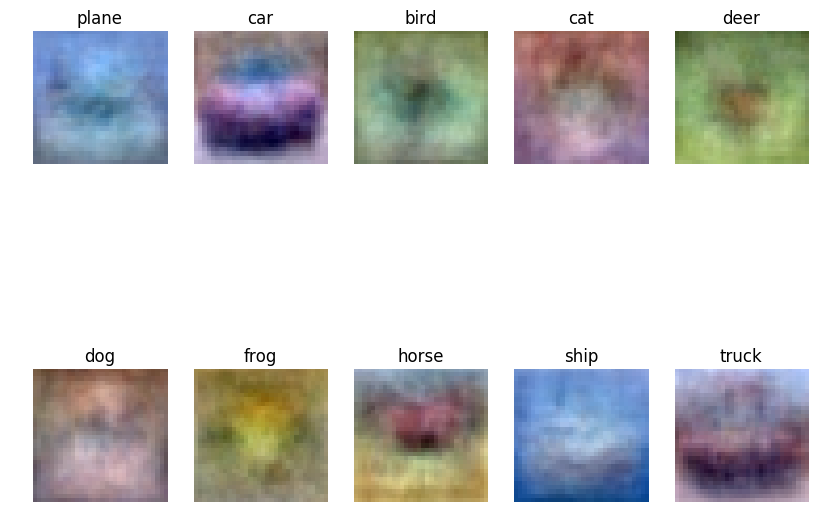

In [72]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])